In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import spacy
import json
import numpy as np
import pandas as pd
import re
import string
import multiprocessing
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS

In [96]:
pwd

'/Users/cpan/Desktop/project/notebooks'

In [32]:
save_json_file_path = '/Users/cpan/OneDrive - Guardant Health/clean_test_results/labeled_test_results.json'

In [33]:
with open(save_json_file_path, "r") as f:
    data = json.load(f)

In [50]:
print(len(data))

2793


In [21]:
from sklearn.feature_extraction import text

In [22]:
type(text.ENGLISH_STOP_WORDS)

frozenset

In [23]:
custom_stopwords = ['information', 'patient', 'redacted', 'REDACTED', 'redactedredacted', "fax", "page", 'patient', 'mg', 'clinical', 'cancer', 'diego' 'san', 'null', 'file', 'printed', 'information', 'mg', 'report', 'final']
my_stopwords = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

In [24]:
ner_basic = spacy.load("en_core_web_sm")

In [26]:
def median_page_num_per_folder(data):
    # Create a DataFrame
    df = pd.DataFrame(data)

    # Extract folder names
    df['folder_name'] = df['file_name'].str.split('/').str[0]

    # Group by folder name and calculate the median number of pages per folder
    median_pages_per_folder = df.groupby('folder_name')['file_name'].count().median()

    print("Median number of pages per folder:", median_pages_per_folder)


In [27]:
median_page_num_per_folder(data)

Median number of pages per folder: 2.0


In [28]:
# average number of pages that mention test per folder(medical record) 
def avg_page_num_per_folder(data):
    # Create a DataFrame
    df = pd.DataFrame(data)

    # Extract folder names
    df['folder_name'] = df['file_name'].str.split('/').str[0]

    # Group by folder name and calculate the average number of pages per folder
    average_pages_per_folder = df.groupby('folder_name')['file_name'].count().mean()

    print("Average number of pages per folder:", average_pages_per_folder)

In [29]:
avg_page_num_per_folder(data)

Average number of pages per folder: 3.93935119887165


In [35]:
# Function to perform text cleaning using spaCy, filter out digits, and exclude stopwords
def preprocess_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove dates
    text = re.sub(r'\d{1,2}\/\d{1,2}\/\d{4}', '', text)

    # Remove special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

def clean_text(text_):
    text = preprocess_text(text_)
    doc = ner_basic(text)
    cleaned_text = " ".join(token.lemma_ for token in doc if not (token.is_punct or token.is_digit or token.is_stop or token.lemma_ in my_stopwords))
    return cleaned_text

# combine page content with clean_text and filtering out digits and stopwords
def combine_page_content(data):
    all_pages = []
    for item in data:
        file_name = item['file_name']  # Get the file name
        tests = item['tests']
        page_content = item['page_content'] # page content from one page
        # skip those pages with empty test results
        if len(tests)<1:
            continue
        cleaned_page = clean_text(page_content)
        # store file_name, cleaned_pages to keep track of the pages in cluster 
        all_pages.append((file_name, cleaned_page))
    return all_pages

def get_page_content(pages):
    all_pages = []
    for _, page_content in pages:
        all_pages.append(page_content)
    return all_pages

In [36]:
def custom_tokenizer(text):
    tokens = text.split()  # Split text into tokens
    filtered_tokens = [token for token in tokens if len(token) > 2]  # Exclude tokens with one element
    return filtered_tokens

In [37]:
print(len(data))

2793


In [38]:
all_pages_with_filename = combine_page_content(data)
all_page_content = get_page_content(all_pages_with_filename)

In [93]:
joblib.dump(all_pages_with_filename, 'all_pages_with_filenames.pkl')
joblib.dump(all_page_content, 'all_page_content.pkl')

['all_page_content.pkl']

In [39]:
all_page_content[0]

'  lp faxq         frankle globulin   fhl interface    avg ratio   hl interface    bilirubin total   fhl interface    alkaline phosphatase   hl interface    sgotast   hl interface    sgptalt   hl interface    gfr nonafrican american astimate   hl interface    gfr african american estimate   fhl interface    tumor marker redact   hl interface    p    hl interface    cbc auto differential hl interface    comprehensive metabolic panel hl interface    outside rx calcium    d po solid calcium carbonatevitamin d outside rx antoinette regalado   vitamin d po solid cholecalciferol vitamin d outside rx   effexor xr po solid sr venlafaxine hel outside rx antoinette regalado   prescription letrozole po solid   tablets   po daily prevent breast raturn instruction   po daily prevent breast return date start   antoinette regalado   ondansetron odt ondansetron   tablet dispersible lingual dissolve tongue qh prn nausea constipate dispense   refill   dispense childproof cap redact   tx   ph erx d e   f

In [40]:
# tf-idf tokenizer 
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=list(my_stopwords), token_pattern=r'\b[^\d\W]+\b', preprocessor=preprocess_text, use_idf=True)
data_vectorized = vectorizer.fit_transform(all_page_content)

/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [94]:
joblib.dump(vectorizer, 'vectorizer_kmeans.pkl')

['vectorizer_kmeans.pkl']

In [95]:
joblib.dump(preprocess_text, 'preprocess_text_kmeans.pkl')

['preprocess_text_kmeans.pkl']

In [56]:
joblib.dump(data_vectorized, 'data_vectorized_kmeans.pkl')

['data_vectorized_kmeans.pkl']

### K-Means Clustering

In [58]:
# Function to find the optimal number of clusters using the Elbow method
def find_optimal_clusters(data, max_clusters):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    return inertias

In [59]:
# Maximum number of clusters to try
max_clusters = 10

# Find the optimal number of clusters for each cancer type
data_inertias = find_optimal_clusters(data_vectorized, max_clusters)

/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


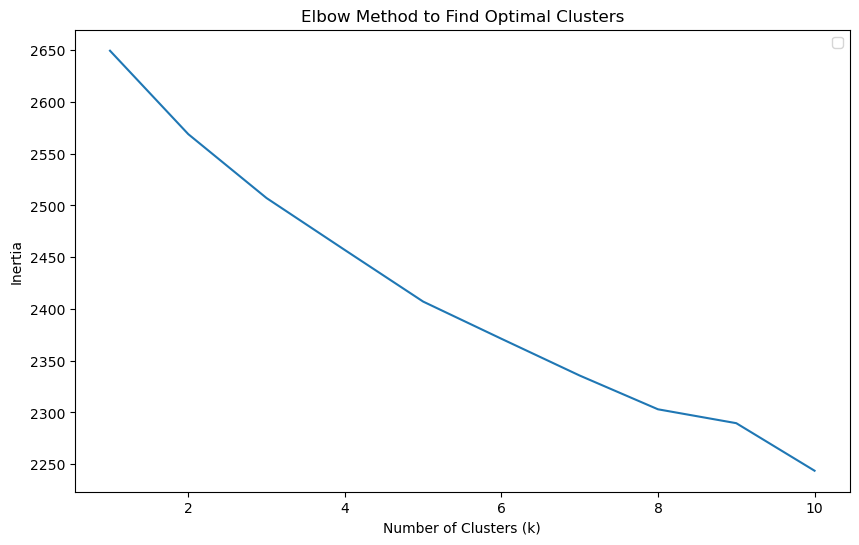

In [60]:
# Plot the inertia values for each cancer type
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), data_inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Find Optimal Clusters')
plt.legend()
plt.show()

In [61]:
optimal_clusters = 8

In [62]:
def fit_kmeans_and_get_top_keywords(data, file_names, num_clusters, num_top_keywords=10):
    # page_contents = get_page_content(data)
    # TF-IDF vectorization
    # vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=list(my_stopwords), token_pattern=r'\b[^\d\W]+\b', preprocessor=preprocess_text, use_idf=True)
    # data_vectorized = vectorizer.fit_transform(page_contents)

    # Fit KMeans clustering on the data
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_vectorized)

    # Extract cluster keywords
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]  # Sort cluster centers by proximity to centroid
    terms = np.array(vectorizer.get_feature_names_out())   # Get the feature names (terms)

    cluster_keywords = {}
    cluster_file_names = {i: [] for i in range(num_clusters)}  # Initialize dictionary to store file names for each cluster

    for cluster_idx in range(num_clusters):
        top_keyword_indices = order_centroids[cluster_idx, :num_top_keywords]
        top_keywords = [terms[idx] for idx in top_keyword_indices]

        # Store the top keywords for the current cluster
        cluster_keywords[cluster_idx] = top_keywords

    # Assign file names to their respective clusters
    for idx, (file_name, _) in enumerate(data):
        cluster_file_names[clusters[idx]].append(file_name)

    return kmeans, clusters, cluster_keywords, cluster_file_names

In [63]:
data_file_names = [item['file_name'] for item in data]

In [65]:
# Fit KMeans and get top keywords while keeping track of file names for each cluster
kmeans, clusters, cluster_keywords, cluster_file_names = fit_kmeans_and_get_top_keywords(all_pages_with_filename, data_file_names, optimal_clusters)

In [66]:
pwd

'/Users/cpan/Desktop/project/notebooks'

In [67]:
import joblib

# Save KMeans model, clusters, cluster_keywords, and cluster_file_names
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(clusters, 'kmeans_clusters.pkl')
joblib.dump(cluster_keywords, 'kmeans_cluster_keywords.pkl')
joblib.dump(cluster_file_names, 'kmeans_cluster_file_names.pkl')

['kmeans_cluster_file_names.pkl']

In [68]:
# from sklearn.externals import joblib

# # Load KMeans model, clusters, cluster_keywords, and cluster_file_names
# kmeans = joblib.load('kmeans_model.pkl')
# kmeans_clusters = joblib.load('kmeans_clusters.pkl')
# kmeans_cluster_keywords = joblib.load('kmeans_cluster_keywords.pkl')
# kmeans_cluster_file_names = joblib.load('kmeans_cluster_file_names.pkl')


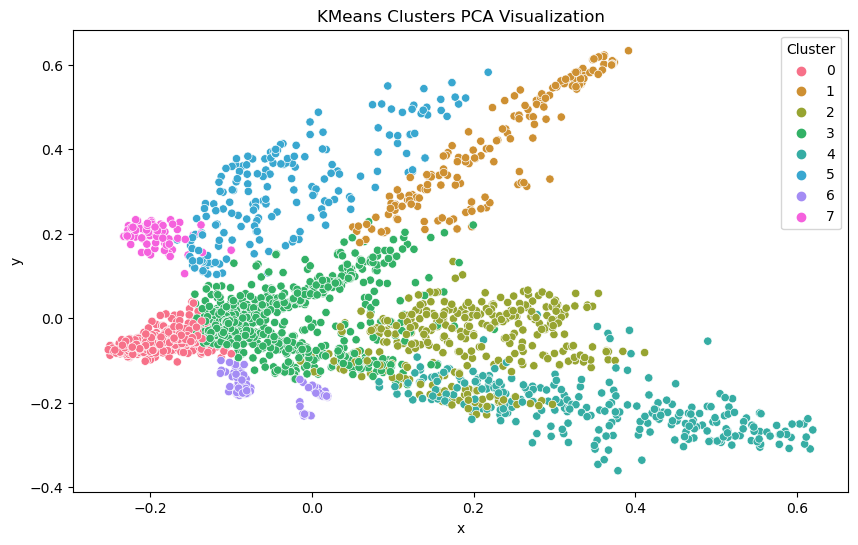

In [69]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Fit PCA or t-SNE on the data_vectorized
# For example, using PCA:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vectorized.toarray())

# Or using t-SNE:
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# reduced_data = tsne.fit_transform(data_vectorized.toarray())

# Create a DataFrame with reduced data and cluster labels
cluster_df = pd.DataFrame({'x': reduced_data[:, 0], 'y': reduced_data[:, 1], 'cluster': clusters})

# Set up a colormap
cmap = sns.color_palette("husl", n_colors=optimal_clusters)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='cluster', data=cluster_df, palette=cmap)
plt.title("KMeans Clusters PCA Visualization")
plt.legend(title="Cluster")
plt.show()


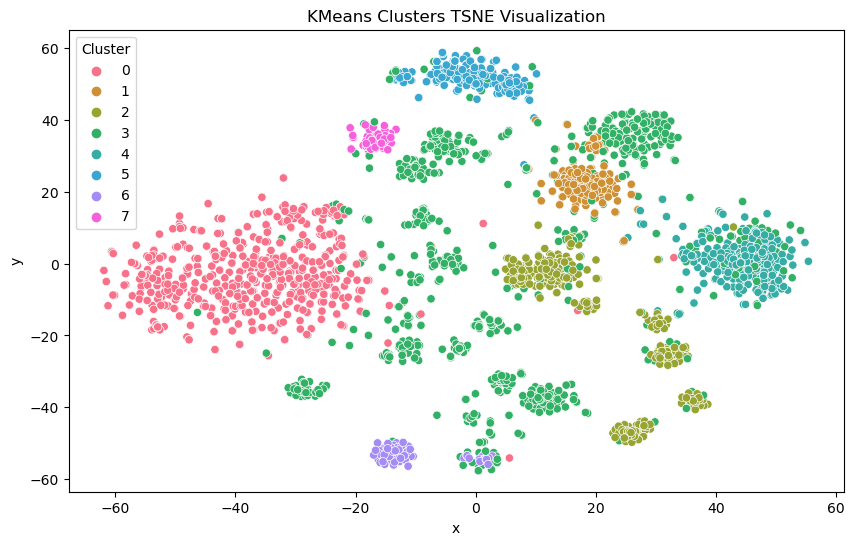

In [70]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Fit PCA or t-SNE on the data_vectorized
# For example, using PCA:
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(data_vectorized.toarray())

# Or using t-SNE:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_data = tsne.fit_transform(data_vectorized.toarray())

# Create a DataFrame with reduced data and cluster labels
cluster_df2 = pd.DataFrame({'x': reduced_data[:, 0], 'y': reduced_data[:, 1], 'cluster': clusters})

# Set up a colormap
cmap = sns.color_palette("husl", n_colors=optimal_clusters)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='cluster', data=cluster_df2, palette=cmap)
plt.title("KMeans Clusters TSNE Visualization")
plt.legend(title="Cluster")
plt.show()

In [71]:
def create_keyword_dataframe(cluster_keywords, num_top_keywords=10):
    data = []
    for cluster_id, keywords in cluster_keywords.items():
        keywords_list = keywords[:num_top_keywords] + ['N/A'] * (num_top_keywords - len(keywords))
        data.append([cluster_id + 1] + keywords_list)

    columns = ["Cluster"] + [f"Top Keyword {i+1}" for i in range(num_top_keywords)]
    df = pd.DataFrame(data, columns=columns)
    return df

In [72]:
keywords_df = create_keyword_dataframe(cluster_keywords)

In [73]:
keywords_df

,Cluster,Top Keyword 1,Top Keyword 2,Top Keyword 3,Top Keyword 4,Top Keyword 5,Top Keyword 6,Top Keyword 7,Top Keyword 8,Top Keyword 9,Top Keyword 10
0,1,right,pain,discuss,note,disease,today,history,lung,negative,plan
1,2,additional,relevance,detailed,email,available,service,detect,client,guardant,therapy
2,3,alteration,detect,somatic,amplification,biomarker,blood,circulate,gene,cellfree,guardant
3,4,guardant,gene,result,portal,service,test,health,redact,laboratory,contact
4,5,variant,map,response,tumor,plot,fraction,allele,cfdna,test,guardant
5,6,phase,trial,state,nct,portalguardanthealthcom,study,visit,available,solid,office
6,7,analytical,biomarker,category,performance,ctdna,evidence,diagnostic,demonstrate,significance,companion
7,8,phase,carcinoma,inhibitor,solid,tumor,cell,leukemia,breast,lung,nsclc


In [63]:
# clusters that seem to contain important words that indicate test results
# cluster 1: history, disease
# cluster 3: biomarker, gene
# cluster 5: tumor, variant, test 
# cluster 6: biomarker, evidence, diagnostic

In [74]:
print(len(cluster_file_names[0] ))

744


In [75]:
# select the cluster that represent the test result the most 
# manually discover cluster 0, 3, 5, 6 are closer clusters together 
# key_file_names = cluster_file_names[0]+  cluster_file_names[3]+cluster_file_names[5]+cluster_file_names[6]
# print(len(key_file_names))

In [76]:
# clustered_page_content = []
# for item in data: 
#     file_name = item['file_name']
#     if file_name in key_file_names:
#         page_content = item['page_content']
#         clustered_page_content.append(page_content)

### Find Closest Clusters

### pairwise distance 

In [77]:
from sklearn.metrics import pairwise_distances_argmin_min

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

In [84]:
from scipy.spatial.distance import cdist

# Calculate pairwise distances between cluster centers
distances = cdist(cluster_centers, cluster_centers, metric='euclidean')

# Set diagonal elements (distance to itself) to a large value
np.fill_diagonal(distances, np.inf)

# Find indices of the closest cluster pair
row_idx, col_idx = np.unravel_index(np.argmin(distances), distances.shape)

# Get the actual distance
min_distance = distances[row_idx, col_idx]

# Get the cluster indices
closest_cluster_1 = row_idx
closest_cluster_2 = col_idx

print(f"Clusters {closest_cluster_1} and {closest_cluster_2} are closest with a distance of {min_distance:.4f}")


Clusters 0 and 3 are closest with a distance of 0.2642


In [85]:
closest_key_file_names = cluster_file_names[0]+  cluster_file_names[3]
print(len(closest_key_file_names))

1628


In [86]:
print(closest_key_file_names[:2])

['A0120605/image-003.txt', 'A0120605/image-001.txt']


In [87]:
pwd

'/Users/cpan/Desktop/project/notebooks'

In [88]:
# export closest key file names 
# Specify the path for the output text file
# path_txt =  '/Users/cpan/OneDrive - Guardant Health/page_classification_data/'
# output_file_path = 'closest_key_file_names.txt'

# # Write the file names to the output text file
# with open(path_txt + output_file_path, 'w') as file:
#     for file_name in closest_key_file_names:
#         file.write(f"{file_name}\n")

# print("File names exported to:", output_file_path)

File names exported to: closest_key_file_names.txt


In [92]:
# get those cloesest cluster pages 
# closest_clustered_page_content = []
# for item in data: 
#     file_name = item['file_name']
#     if file_name in key_file_names:
#         page_content = item['page_content']
#         closest_clustered_page_content.append(page_content)

### Nearest Neighbors

In [79]:
from sklearn.neighbors import NearestNeighbors

# Create Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=2, metric='euclidean')
nn_model.fit(cluster_centers)

# Find nearest neighbors for each cluster center
nearest_neighbors = nn_model.kneighbors(n_neighbors=2, return_distance=False)

# Find cluster pairs with neighbors in common
close_cluster_pairs = set()
for i, neighbors in enumerate(nearest_neighbors):
    close_cluster_pairs.add(tuple(sorted([i, neighbors[1]])))

print("Close Cluster Pairs:", close_cluster_pairs)


Close Cluster Pairs: {(2, 4), (1, 2), (3, 7), (0, 6), (2, 3), (0, 2), (0, 5)}


Based on previous manual keyword observations, the clusters closer to each other are 0, 3, 5, 6

The closer cluster pairs shown by nearest neighbors are: 
- 0 and 6
- 0 and 2
- 0 and 5 